# Relative Expanded  Uncertainty (REU)

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
import scipy.stats
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
import os
from datetime import datetime

In [38]:
def REU_list(DF, Pollutant, Units, Lambda = 1, u_xi = 0.0):
    '''This function allows us to calculate the relative expanded uncertainty
    Variables:
    DF: It is a dataframe with the satellite AOD values (MAIAC and MODIS) and the AERONET reference AOD
    Pollutant: name of the reference pollutant, in our case AERONET
    Units: name of the variables we want to analyze. In our case MAIAC and MODIS
    '''
    
    #NOTE: Sigma_err_x (NILU notation) is the same as u_xi (GDE2010 notation)
    Sigma_err_x = u_xi
    # These are lists where I will save the different results
    list_u = []
    list_reu = []
    list_bias = []
    list_noise = []
    list_reux = []
    list_biasx = []
    list_noisex = []
    list_verificacion = []
  
    # The UNITS are covered, that is, the pollutant to be analyzed. In our case MAIAC and MODIS
    for Unit in Units:
        x = DF[Pollutant] #AERONET
        y = DF[Unit] # Pollutant
        
        #Masking the NaN's
        mask = ~np.isnan(x) & ~np.isnan(y)
        x = x[mask]
        y = y[mask]
        n = len(x)
        
        #Slope & Intercept usando REGRESION LINEAL (LR)
        slope, intercept, r, p, stderr = scipy.stats.linregress(x[mask], y[mask])
        b1 = slope
        b0 = intercept
        
        #Equation error variance for y = b0 + b1*x + v_i

        rss = (y - b0 - b1*x)**2
        RSS = rss.values.sum()
        Sigma_v_sqr = RSS/(n-2)
                
        #Error variance due to the deviation of the 1:1 line
        ec = (b0 + (b1 - 1)*x)**2
        ran = Sigma_v_sqr - Sigma_err_x**2
        
        #Results
        
        U = ((ran + ec)**(1/2))
        
        REU = ((2*100)/y)*U
        
        bias = ((((2*100)/y)**2)*ec)**(1/2)
        
        noise = ((((2*100)/y)**2)*ran)**(1/2)
        
        verificacion = ((bias**2 + noise**2)**(1/2))
        verificacion_u = ((bias**2 + noise**2)**(1/2))/((2*100)/y)
        
        REUx = 2*U*100/x
        
        biasx = ((((2*100)/x)**2)*ec)**(1/2)
        
        noisex = ((((2*100)/x)**2)*ran)**(1/2)
        
        #The results are each placed in a separate list
        list_u.append(U)
        list_reu.append(REU)
        list_bias.append(bias)
        list_noise.append(noise)
        list_verificacion.append(verificacion)
        list_reux.append(REUx)
        list_biasx.append(biasx)
        list_noisex.append(noisex)
    
    # The generated lists are concatenated
    U = pd.concat(list_u, axis=1)
    Col_Names=[]
    for i in Units:
        i = 'U_'+ i
        Col_Names.append(i)
    U.columns = Col_Names
    U.rename_axis("Timestamp", axis='index', inplace=True)
    
    REU = pd.concat(list_reu, axis=1)
    Col_Names=[]
    for i in Units:
        i = 'REU_'+ i
        Col_Names.append(i)
    REU.columns = Col_Names
    REU.rename_axis("Timestamp", axis='index', inplace=True)
    
    bias = pd.concat(list_bias, axis=1)
    Col_Names=[]
    for i in Units:
        i = 'b_'+ i
        Col_Names.append(i)
    bias.columns = Col_Names
    bias.rename_axis("Timestamp", axis='index', inplace=True)
    
    noise = pd.concat(list_noise, axis=1)
    Col_Names=[]
    for i in Units:
        i = 'n_'+ i
        Col_Names.append(i)
    noise.columns = Col_Names
    noise.rename_axis("Timestamp", axis='index', inplace=True)
    
    verificacion = pd.concat(list_verificacion, axis =1 )
    Col_Names=[]
    for i in Units:
        i = 'verificacion_'+ i
        Col_Names.append(i)
    verificacion.columns = Col_Names
    verificacion.rename_axis("Timestamp", axis='index', inplace=True)
    
    REUx = pd.concat(list_reux, axis=1)
    Col_Names=[]
    for i in Units:
        i = 'REUx_'+ i
        Col_Names.append(i)
    REUx.columns = Col_Names
    REUx.rename_axis("Timestamp", axis='index', inplace=True)
    
    biasx = pd.concat(list_biasx, axis=1)
    Col_Names=[]
    for i in Units:
        i = 'bx_'+ i
        Col_Names.append(i)
    biasx.columns = Col_Names
    biasx.rename_axis("Timestamp", axis='index', inplace=True)
    
    noisex = pd.concat(list_noisex, axis=1)
    Col_Names=[]
    for i in Units:
        i = 'nx_'+ i
        Col_Names.append(i)
    noisex.columns = Col_Names
    noisex.rename_axis("Timestamp", axis='index', inplace=True)
    
   
    REUyx = pd.concat((DF[Pollutant], U, REU, bias, noise, REUx, biasx, noisex,verificacion), axis=1)#, 

    
    return REUyx

In [90]:
# REU PLOT
def REU_plot(path, date_format,nrows,ncols,color_modis,color_maiac):
    '''
    This function allows plotting the previously calculated REU. 
    The data of each station of interest is contained in a folder in .csv format previously processed.
    This function goes through the folder and takes each of these files to later make the plot of interest.

    Variables:
    - path : path to the folder where the files in .csv format are located
    - date_format: format of the date column of the file of interest. 
    For example: date_format='%Y-%m-%d %H:%M:%S'
    - nrows: number of rows the plot will have
    - ncols: number of columnas the plot will have
    - color palette for each  for stations MAIAC-MODIS For example: 
    color_modis = ["#74c476","#fed976","#fb6a4a", "#74a9cf","#df65b0","#807dba"]
    color_maiac = ["#005a32","#fd8d3c","#99000d","#023858","#ce1256","#3f007d"]
    '''
    i=0 
    j=0 
    edge_color_maiac = ["#004529", "#feb24c","#67000d","#081d58","#67001f","#4d004b"]
    edge_color_modis = ["#41ab5d","#feb24c","#cb181d","#045a8d","#ce1256","#810f7c"]
    

    fig, ax = plt.subplots(ncols=ncols,nrows=nrows,  figsize=(14,6),dpi=500)
    #The folder where the files of each station are located is browsed.
    for p,files in enumerate(os.listdir(path)):
        N = len(os.listdir(path))
        data = pd.read_csv(os.path.join(path,files))
        #A column is created with the date called "Timestamp".
        data["Timestamp"] = data["date"].apply(lambda x: datetime.strptime(x,date_format))
        #Becomes the index column
        data.set_index('Timestamp', inplace = True)
        data_mean_period_len =len(data.dropna(how='all'))
        
        
        df_REUxy = REU_list(DF = data, Pollutant = 'AOD_550_AER_mean', 
        Units = ["AOD_550_MAIAC_mean","AOD_550_MODIS_mean"], 
        Lambda = 1, u_xi = 0.0)
        # Station Name
        station_name = files [2:4]
        ########################                VARIABLES                ########################
        
        
        x = df_REUxy["AOD_550_AER_mean"]
        y_maiac = df_REUxy["REUx_AOD_550_MAIAC_mean"]
        y_modis = df_REUxy["REUx_AOD_550_MODIS_mean"]
        n = len(x)
        min_maiac = round(min(df_REUxy["REUx_AOD_550_MAIAC_mean"]),2)
        min_modis  =  round(min(df_REUxy["REUx_AOD_550_MODIS_mean"]),2)

        print(min_maiac)     

        print(files)
        ########################                PLOT                ########################
        # Figure
        #Scatter plot REU vs Ref
        ax[i][j].scatter(x, y_maiac, s=10, color=color_maiac[p], alpha=0.5, linewidth=1) # Color
        ax[i][j].scatter(x, y_modis, s=10, color= color_modis[p], alpha=0.5, linewidth=1) # Color
        ax[i][j].grid(color = 'grey', linestyle = '--', linewidth = 0.2)

       # The line with the minimum value of MIAC and MODIS is added
        ax[i][j].hlines(y= min_modis, xmin=0, xmax=1.2, color='black', linewidth=1, alpha=0.8, linestyle = '--')
        ax[i][j].hlines(y=min_maiac , xmin=0, xmax=1.2, color='black', linewidth=1, alpha=0.8, linestyle = '--')

        
        ax[i][j].text(0.8, min_maiac+5,(f'$REU = {min_maiac}$'),
                      ha="left", va="center",fontdict={'family': 'serif', 
                     'color' : 'Black',
                     'weight': 'bold',
                     'size': 9})
        ax[i][j].text(0.8,  min_modis+5,(f'$REU = {min_modis}$'),
                      ha="left", va="center",fontdict={'family': 'serif', 
                     'color' : 'Black',
                     'weight': 'bold',
                     'size': 9})

        # Title of each subplot corresponds toY the name of the AERONET station.
        ax[i][j].set_title(station_name,fontsize=13,fontdict={'family': 'serif', 
            'color' : 'Black',
            'weight': 'bold',
            'size': 16})
        # X axis limit
        ax[i][j].set_xlim(0,1.2) 
        # Y axis limit
        ax[i][j].set_ylim(0,300)
        # Axes names
        ax[i][j].set_xlabel(r'$AOD_{AERONET}$',size=10)
        ax[i][j].set_ylabel(r'$AOD_{MAIAC}$',size=10)
        # Configuration of subplots
        plt.subplots_adjust(left=0.125,bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)
        # Tittle legend
        tittle_legend = ["MAIAC","MODIS"]
        ax[i][j].legend(tittle_legend , frameon = False, markerfirst = False, fontsize = 10)
        # Location of data in each subplot
        print(i,j,p,station_name)

        if j == ncols-1:
            i = i+1
            j = 0
        else:
            j = j+1
    
    return(plt.show())

71.01
1_SP-25KM-MMA-60-AER.csv
0 0 0 SP
84.85
2_ST-25KM-MMA-60-AER.csv
0 1 1 ST
72.43
3_BA-25KM-MMA-60-AER.csv
0 2 2 BA
56.5
4_MD-25KM-MMA-60-AER.csv
1 0 3 MD
64.7
5_LP-25KM-MMA-60-AER.csv
1 1 4 LP
64.83
6_MX-25KM-MMA-60-AER.csv
1 2 5 MX


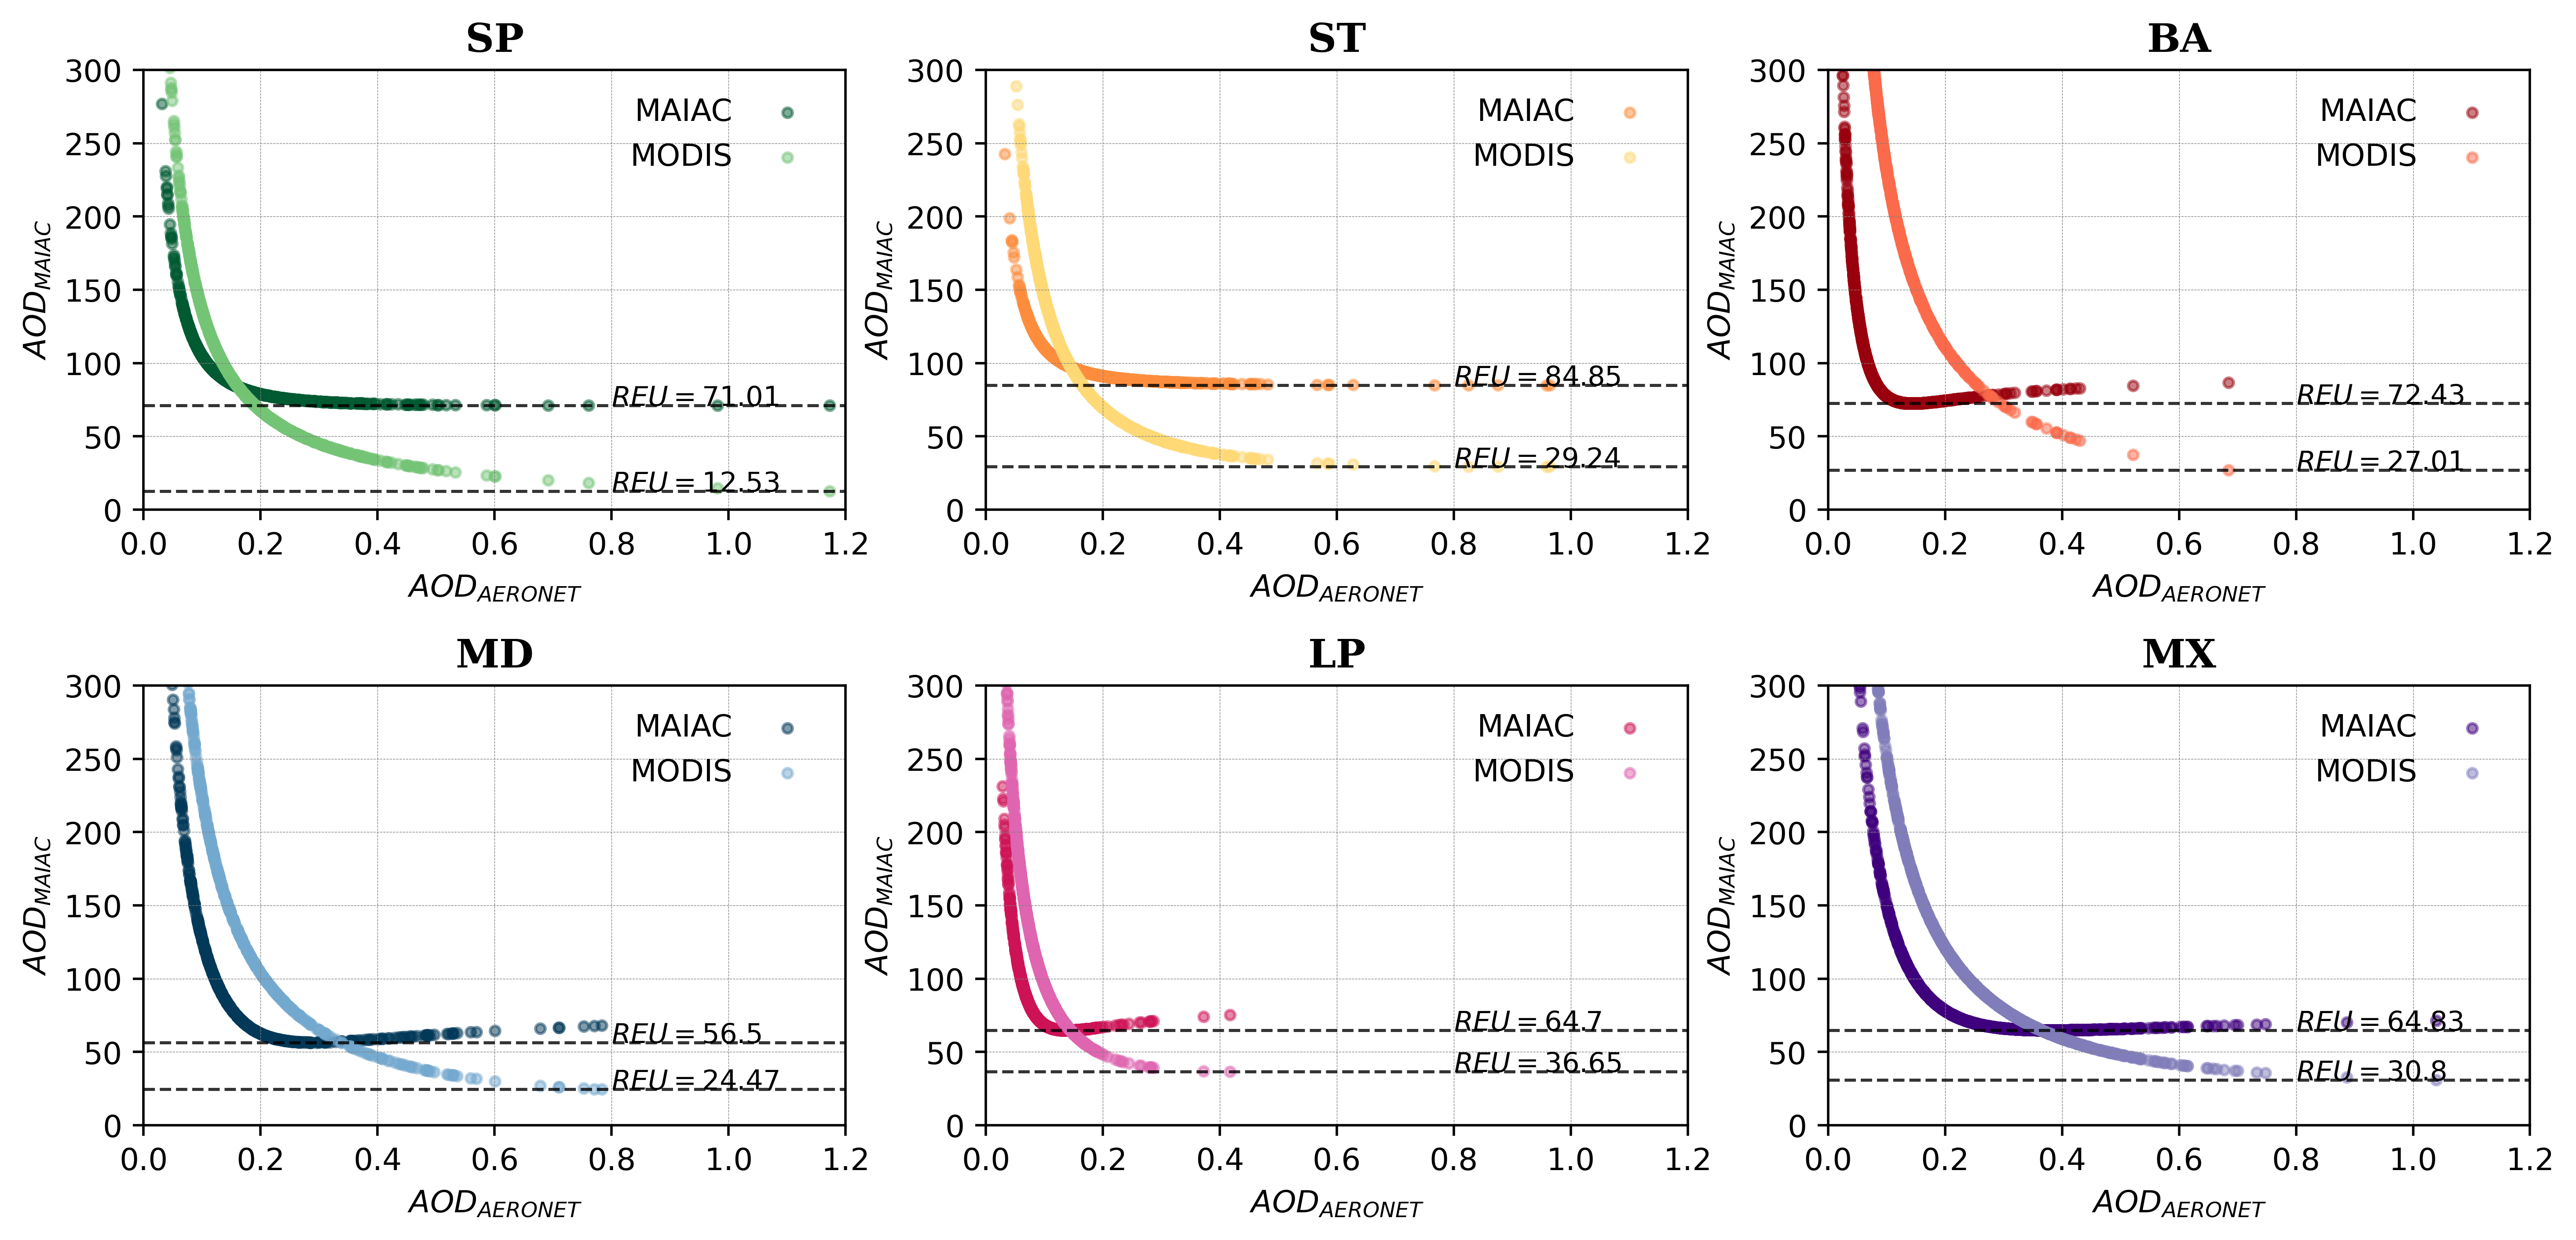

In [89]:
REU_plot(path="D:/Josefina/papers_escritos/paper_maiac/datasets/processed/MMA/",date_format='%Y-%m-%d',nrows=2,ncols=3,color_modis = ["#74c476","#fed976","#fb6a4a", "#74a9cf","#df65b0","#807dba"],color_maiac = ["#005a32","#fd8d3c","#99000d","#023858","#ce1256","#3f007d"])
